# Metadata

```yaml
Course:    DS 5001 
Module:    09 Lab
Topic:     Using GloVe
Author:    R.C. Alvarado
Date:      28 March 2023 (revised)
```

**Purpose:** We use some pretrained word vectors from [the developers of GloVe](https://nlp.stanford.edu/projects/glove/).

# About GloVe

> Unlike the matrix factorization methods, the shallow window-based methods [e.g. word2vec] suffer \
> from the disadvantage that **they do not operate directly on the co-occurrence statistics of the corpus.** \
> Instead, these models scan context windows across the entire corpus, which fails to take advantage of the \
> vast amount of repetition in the data.

# Set Up

In [1]:
import configparser
config = configparser.ConfigParser()
config.read("../../../env.ini")
data_home = config['DEFAULT']['data_home']
output_dir = config['DEFAULT']['output_dir']
local_lib = config['DEFAULT']['local_lib']

In [2]:
data_in = f'{data_home}/glove'
# db_file = f'{data_in}/glove2.db'

In [3]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.metrics.pairwise import cosine_similarity

# Import GloVe data

We import a word embedding with 400,000 token types and 50. 100, 200, or 300 features.

In [4]:
n_features = 100 # 50, 100, 200, 300

In [5]:
glove = pd.read_csv(f"{data_in}/glove.6B/glove.6B.{n_features}d.txt", sep="\s", header=None, engine='python')
glove = glove.set_index(0)
glove.index.name = 'term_str'
glove = glove.astype(float)

In [6]:
glove.shape

(400000, 100)

In [7]:
glove.sample(10)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
term_str,,,,,,,,,,,,,,,,,,,,,
358,0.629300,0.500540,0.540120,0.35961,-0.123940,0.603050,0.622870,0.186430,-0.438810,-0.159650,...,-0.094675,0.613670,-0.426460,-0.497820,-0.20381,0.23410,0.096084,0.034860,-0.345920,-0.412500
tetradze,0.624480,-0.133110,-0.193230,0.33688,0.031628,0.122080,-0.385780,-0.138640,0.473580,-0.332940,...,0.528260,0.268330,0.217600,-0.519390,-0.10760,0.52615,0.769090,0.045849,-0.423530,-0.496610
anfernee,0.512790,-0.255720,0.394660,-1.20920,-0.002138,0.579590,-0.981500,0.454470,0.177420,-0.027780,...,-1.055900,0.037884,-0.185130,-0.702510,-1.41290,-0.30667,0.398410,-0.807950,-1.486800,0.093308
conformity,-0.193120,0.042083,0.537780,-0.11200,-0.611750,0.592930,-0.308510,-0.210940,-0.269480,0.703730,...,-0.193700,-0.067363,-0.769370,0.571970,0.41028,0.15259,-0.182070,-0.660930,-0.294960,0.450460
jackrabbits,0.115270,-0.346840,0.488600,-0.23296,-0.688220,0.050504,-0.128170,0.563830,-0.281220,-0.001396,...,-0.627210,-0.307330,-0.119190,0.123040,-0.58255,-0.79974,-0.646570,0.358000,-0.256600,-0.063230
rubai,0.238190,-0.267000,-0.461010,0.12470,0.162350,-0.499410,-0.094871,-0.173290,0.579090,-0.173850,...,0.063014,-0.787840,0.948730,0.276870,0.86500,0.12401,0.075803,-0.387930,-0.884390,-0.846050
33,0.231590,0.454840,0.025540,-0.25891,0.483050,0.108950,0.591930,0.008396,-1.012800,0.252490,...,0.172390,0.244800,-0.000799,-0.276040,-1.28110,0.43776,-0.241600,0.003375,0.136980,-0.378280
xinbei,-0.044129,-0.745090,-0.063585,-0.81758,1.062500,-0.082076,-0.498770,0.444830,1.087500,1.038000,...,0.185520,-0.056590,-0.279640,-0.400020,-0.72496,0.48100,1.078800,0.614140,0.219150,-0.278430
r1a,0.208850,0.318110,-0.007129,0.12402,0.024359,-0.027899,-0.040294,-0.167230,0.053857,-0.096939,...,-0.585590,0.097826,-0.091612,-0.185960,0.26052,-0.27208,-0.148880,-0.292390,0.007376,-0.230880


# Explore Features

In [8]:
test_sentence = sorted(list(set("the quick brown fox jumped over the lazy dogs".split())))

In [9]:
glove.loc[test_sentence].T.sample(10).T\
    .style.format(precision=2).background_gradient(cmap='YlGnBu', axis=None)

,81,32,40,63,23,26,82,36,5,39
term_str,,,,,,,,,,
brown,0.45,0.69,0.58,-0.30,0.02,0.96,0.16,0.60,0.11,0.28
dogs,1.01,-0.25,-0.09,0.42,-0.07,0.64,0.04,0.38,-0.79,0.83
fox,-0.35,1.06,0.74,0.14,0.09,0.64,-0.61,0.73,0.04,0.50
jumped,0.53,0.45,0.14,-0.70,0.55,-0.32,0.97,0.52,0.50,0.67
lazy,-0.11,0.61,0.21,-0.61,-0.20,0.77,0.26,0.73,-0.94,0.85
over,1.33,0.36,0.25,0.10,0.60,-0.43,-0.39,0.39,-0.03,-0.47
quick,1.10,0.33,0.08,-0.08,-0.33,0.92,0.05,-0.22,-0.32,0.08
the,0.71,0.28,-0.08,0.03,0.35,-0.47,0.50,0.09,0.08,0.17


In [10]:
FEATURE = glove.mean().to_frame('mean_weight')
FEATURE['max_weight'] = glove.max()
FEATURE['min_weight'] = glove.min()
FEATURE['max_word'] = glove.idxmax()
FEATURE['min_word'] = glove.idxmin()

In [11]:
# FEATURE.sample(10)

# Are embedding features like topics?

In [12]:
FEATURE['top_words'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [13]:
FEATURE.sort_values('mean_weight', ascending=False).head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words
56,0.464231,2.4311,-3.6792,sayn,a,sayn microns djordje azarias djukic republish ...
85,0.294030,2.6886,-3.0816,chernykh,patients,chernykh 147.27 warmian-masurian elhanan icasu...
79,0.275634,2.5450,-2.3225,saute,smithee,"saute 0-40 right-arm 10,000-point mixer unsalt..."
95,0.208303,2.6155,-2.1484,ergenekon,lufkin,ergenekon 78-day bulbophyllum sql racketeering...
74,0.196464,2.9406,-2.7764,herein,sfgate.com,herein 79.75 greco-roman lxii highest-rated vi...
50,0.194247,2.2537,-2.7613,abilio,resend,abilio novaya ouvrage zille andry tassos kennet
28,0.194193,2.4583,-2.4019,cosmodrome,shuh,cosmodrome multiplexed xichang plesetsk detona...
42,0.186347,2.5956,-2.8971,zabihullah,tablespoons,zabihullah ayp hizbul foday shamil bhasa asom
41,0.162822,2.9100,-2.2892,estádio,gambari,estádio 225-issue ilich goals-against d'epargn...
48,0.156756,2.6423,-3.2878,passerine,republish,passerine verbandsgemeinde carbonyl birla cred...


# Remove non-words

There are a lot of useless tokens in the vocabulary. These may be good for generating the features, but we don't need them in our queries.

In [14]:
glove = glove.loc[glove.index.dropna()]

In [15]:
# glove

In [16]:
# glove = glove.reset_index().astype(str)
# glove = glove[glove.term_str.str.match(r'^[a-z]+$')]
# glove = glove.set_index('term_str')
glove = glove[glove.index.str.match(r'^[a-z]+$')]

In [17]:
glove = glove.astype(float)
glove.shape

(317754, 100)

In [18]:
# glove.index.value_counts()

In [19]:
FEATURE['top_words2'] = FEATURE.apply(lambda x: ' '.join(glove[x.name].sort_values(ascending=False).head(7).index), axis=1)

In [20]:
FEATURE.head(20)

,mean_weight,max_weight,min_weight,max_word,min_word,top_words,top_words2
1,0.052098,2.4396,-4.0666,bovespa,republish,bovespa 225-issue cac-40 balco knowingly zetas...,bovespa balco knowingly zetas ordinaries sugar...
2,-0.097114,2.5180,-2.3313,distillates,zhongshu,distillates distillate outnumbering expander 2...,distillates distillate outnumbering expander w...
3,-0.138076,2.6546,-2.2963,aonb,right-arm,aonb radomsko keyless text-type (310) update2 ...,aonb radomsko keyless kgalema voivodeship noct...
4,0.110753,3.2142,-2.4469,non-mandatory,porpoises,non-mandatory jonubi certiorari algebraic norm...,jonubi certiorari algebraic normalising barvik...
5,-0.027228,2.7884,-2.4436,baronetage,statesman.com,baronetage longlisted worldsources ayman olyā ...,baronetage longlisted worldsources ayman mcca ...
6,-0.003264,2.5575,-2.6252,c/d,petroleum,c/d 33-1-47-42-80-44 lycaenidae chanting canon...,lycaenidae chanting canons mobs catholic chant...
7,0.031764,2.2657,-2.4128,g6,sensex,g6 undervotes glafcos agusta lancer yearling s...,undervotes glafcos agusta lancer yearling span...
8,-0.050769,2.2472,-2.4823,weekdays,jacobite,weekdays saturdays vidhan canvassing panamá fi...,weekdays saturdays vidhan canvassing fille com...
9,0.153216,2.7588,-2.7738,otros,unbeaten,otros paises tambien estan (816) castile-la jaane,otros paises tambien estan jaane latinoamerica...
10,-0.023674,2.3914,-2.2391,hossein,uk-apc,hossein bushehr leed plesetsk warhead vung gan...,hossein bushehr leed plesetsk warhead vung gan...


# Define some semantic functions

In [21]:
def get_word_vector(term_str):
    """Get a numpy array from the glove matrix and shape for input into cosine function"""
    wv = glove.loc[term_str].values.reshape(-1, 1).T
    return wv

def get_sims(term_str, n=10):
    """Get the top n words for a given word based on cosine similarity"""
    wv = get_word_vector(term_str)
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(n)

def get_nearest_vector(wv):
    """Get the nearest word vector to a given word vector"""
    sims = cosine_similarity(glove.values, wv)
    return pd.DataFrame(sims, index=glove.index, columns=['score'])\
        .sort_values('score', ascending=False).head(2).iloc[1]

def get_difference(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.subtract(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_sum(a, b):
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = np.add(A, B)
        X = get_nearest_vector(C)
        return X.name
    except ValueError as e:
        print(e)
        return None

def get_analogy(a, b, c):
    """Infer missing analogical term"""
    try:
        A = get_word_vector(a)
        B = get_word_vector(b)
        C = get_word_vector(c)
        D = np.add(np.subtract(B, A), C)
        X = get_nearest_vector(D)
        return X.name
    except ValueError as e:
        print(e)
        return None

# Test similarity function

In [22]:
get_sims('queen')

,score
term_str,
queen,1.000000
princess,0.794724
king,0.750769
elizabeth,0.735571
royal,0.706503
lady,0.704480
victoria,0.685376
monarch,0.668326
crown,0.668056


In [23]:
get_sims('king')

,score
term_str,
king,1.000000
prince,0.768233
queen,0.750769
son,0.702089
brother,0.698578
monarch,0.697789
throne,0.691999
kingdom,0.681141
father,0.680203


In [24]:
get_sims('milk')

,score
term_str,
milk,1.000000
dairy,0.761276
meat,0.748176
sugar,0.734551
yogurt,0.695376
juice,0.694653
cream,0.685067
egg,0.683237
soda,0.676703


In [25]:
get_sims('beer')

,score
term_str,
beer,1.000000
drink,0.818214
drinks,0.798284
liquor,0.732116
coffee,0.725339
vodka,0.724695
wine,0.724451
bottle,0.717643
beers,0.699328


# Test difference function

In [26]:
get_difference('man', 'woman')

'ancelotti'

In [27]:
get_sims('ancelotti')

,score
term_str,
ancelotti,1.000000
ranieri,0.822743
mourinho,0.820027
capello,0.736949
houllier,0.719588
mancini,0.713135
wenger,0.710990
scolari,0.690986
lippi,0.687543


In [28]:
get_difference('woman', 'man')

'miscarry'

In [29]:
get_sims('miscarry')

,score
term_str,
miscarry,1.000000
ovulate,0.628454
breastfeed,0.617344
menstruate,0.600057
miscarried,0.588849
mortify,0.582306
vocalize,0.580238
gestate,0.563410
ovulating,0.562108


In [30]:
get_difference('human', 'culture')

'nonhuman'

In [31]:
get_sims('nonhuman')

,score
term_str,
nonhuman,1.000000
primates,0.697258
habitations,0.623479
fallible,0.617184
beings,0.576165
apes,0.558138
anthropomorphic,0.552706
strepsirrhine,0.545927
vertebrates,0.538547


In [32]:
get_difference('man', 'human')

'fireman'

In [33]:
get_sims('fireman')

,score
term_str,
fireman,1.000000
firefighter,0.717793
paramedic,0.574579
mechanic,0.564724
rescuer,0.551241
chauffeur,0.542937
welder,0.542476
watchman,0.522622
janitor,0.515656


In [34]:
get_difference('human', 'man')

'reproductive'

In [35]:
get_difference('woman', 'human')

'schoolteacher'

In [36]:
get_difference('human', 'woman')

'mechanisms'

In [37]:
get_difference('christianity', 'jesus')

'protestantism'

In [38]:
get_sum('protestantism', 'pope')

'catholicism'

In [39]:
get_sims('protestantism')

,score
term_str,
protestantism,1.000000
catholicism,0.913007
christianity,0.811677
lutheranism,0.800469
calvinism,0.749115
anglicanism,0.729683
orthodoxy,0.673827
methodism,0.672810
hinduism,0.663173


# Test analogy function

## MALE / FEMALE

In [40]:
get_analogy('dog', 'male', 'cat')

'female'

In [41]:
get_analogy('male', 'doctor', 'female')

'nurse'

In [42]:
get_analogy('king', 'queen', 'male')

'female'

In [43]:
get_analogy('king', 'male', 'queen')

'female'

In [44]:
get_analogy('queen', 'female', 'king')

'male'

In [45]:
get_analogy('female', 'princess', 'male')

'queen'

In [46]:
get_analogy('male', 'prince', 'female')

'king'

In [47]:
get_analogy('male', 'father', 'female')

'brother'

In [48]:
get_analogy('female', 'mother', 'male')

'daughter'

In [49]:
get_analogy('woman', 'mother', 'man')

'brother'

In [50]:
get_analogy('woman', 'man', 'female')

'male'

## LEFT / RIGHT

In [51]:
get_analogy('right', 'male', 'left')

'female'

In [52]:
get_analogy('right', 'left', 'male')

'female'

In [53]:
get_analogy('right', 'man', 'left')

'dead'

In [54]:
get_analogy('man', 'woman', 'right')

'woman'

In [55]:
get_analogy('left', 'right', 'white')

'black'

In [56]:
get_analogy('left', 'right', 'black')

'white'

In [57]:
get_analogy('woman', 'man', 'left')

'back'

## OTHER

In [58]:
get_analogy('sun','moon', 'male')

'female'

In [59]:
get_analogy('day', 'sun', 'night')

'sky'

# Experiment

Demonstrate how to project embeddings onto documents

In [60]:
LIB = pd.read_csv(f"{output_dir}/austen-melville-LIB_FIXED.csv").set_index('book_id')

In [61]:
CORPUS = pd.read_csv(f"{output_dir}/austen-melville-CORPUS.csv")\
    .merge(glove, on="term_str")\
    .set_index(['book_id', 'chap_id', 'para_num', 'sent_num', 'token_num'])\
    .iloc[:, 5:]

In [62]:
CORPUS

1         2         3    \
book_id chap_id para_num sent_num token_num                                 
105     1       1        0        0         -0.720780  0.200910 -0.048074   
                4        0        12        -0.720780  0.200910 -0.048074   
                5        0        87        -0.720780  0.200910 -0.048074   
                6        0        11        -0.720780  0.200910 -0.048074   
                7        0        8         -0.720780  0.200910 -0.048074   
...                                               ...       ...       ...   
34970   114     13       0        10        -0.317980 -0.022084 -0.046773   
                         2        8          0.026533  0.041024  0.591940   
                17       0        28        -0.058805 -0.660930  0.845910   
                18       3        11        -0.071764  0.141960  0.169710   
                                  16        -0.071764  0.141960  0.169710   

                                                 4        5        6    \
book_id chap_id para_num sent_num token_num                              
105     1       1        0        0          0.12690 -0.37153 -0.52941   
                4        0        12         0.12690 -0.37153 -0.52941   
                5        0        87         0.12690 -0.37153 -0.52941   
                6        0        11         0.12690 -0.37153 -0.52941   
                7        0        8          0.12690 -0.37153 -0.52941   
...                                              ...      ...      ...   
34970   114     13       0        10         0.19114  0.15238  0.56031   
                         2        8         -0.38357 -0.47097  0.20837   
                17       0        28         0.24791 -0.93616  0.70509   
                18       3        11        -0.20692 -0.44685  0.32946   
                                  16        -0.20692 -0.44685  0.32946   

                                                  7         8        9    \
book_id chap_id para_num sent_num token_num                                
105     1       1        0        0         -0.360620 -0.013027 -1.23200   
                4        0        12        -0.360620 -0.013027 -1.23200   
                5        0        87        -0.360620 -0.013027 -1.23200   
                6        0        11        -0.360620 -0.013027 -1.23200   
                7        0        8         -0.360620 -0.013027 -1.23200   
...                                               ...       ...      ...   
34970   114     13       0        10        -0.474270  0.091121  0.52951   
                         2        8          0.153780 -0.066228  0.48454   
                17       0        28        -0.200220  0.096509  0.51893   
                18       3        11        -0.058106  0.857520  0.23471   
                                  16        -0.058106  0.857520  0.23471   

                                                  10   ...      91        92   \
book_id chap_id para_num sent_num token_num            ...                      
105     1       1        0        0         -1.059500  ...  0.16228 -0.518530   
                4        0        12        -1.059500  ...  0.16228 -0.518530   
                5        0        87        -1.059500  ...  0.16228 -0.518530   
                6        0        11        -1.059500  ...  0.16228 -0.518530   
                7        0        8         -1.059500  ...  0.16228 -0.518530   
...                                               ...  ...      ...       ...   
34970   114     13       0        10         0.304040  ... -0.11525  0.413870   
                         2        8         -1.188600  ...  0.20736 -0.190410   
                17       0        28        -0.019346  ...  0.11950 -0.024223   
                18       3        11         0.387780  ...  0.47100  0.515550   
                                  16         0.387780  ...  0.47100  0.515550   

                                          

In [63]:
BOOKS = CORPUS.groupby('book_id').mean()

In [64]:
BOOKS.T.style.format(precision=2).background_gradient(cmap="YlGnBu", axis=None)

book_id,105,121,141,158,161,946,1212,1342,1900,2701,4045,8118,10712,13720,13721,15422,15859,21816,34970
1,-0.06,-0.05,-0.06,-0.07,-0.05,-0.06,-0.06,-0.06,-0.08,-0.09,-0.08,-0.07,-0.09,-0.09,-0.08,-0.08,-0.07,-0.07,-0.06
2,0.12,0.13,0.13,0.15,0.12,0.14,0.14,0.11,0.12,0.15,0.11,0.14,0.11,0.12,0.15,0.09,0.11,0.17,0.14
3,0.31,0.33,0.32,0.33,0.32,0.35,0.34,0.32,0.31,0.33,0.30,0.31,0.31,0.32,0.32,0.31,0.32,0.36,0.33
4,-0.19,-0.19,-0.19,-0.21,-0.19,-0.18,-0.19,-0.19,-0.16,-0.22,-0.19,-0.23,-0.22,-0.19,-0.22,-0.18,-0.19,-0.21,-0.18
5,-0.07,-0.07,-0.07,-0.11,-0.08,-0.13,-0.10,-0.09,-0.00,-0.02,0.01,-0.03,-0.00,0.00,-0.02,0.00,-0.02,-0.06,-0.01
6,0.24,0.26,0.24,0.23,0.25,0.26,0.27,0.26,0.25,0.22,0.25,0.25,0.25,0.24,0.26,0.24,0.24,0.25,0.28
7,-0.13,-0.14,-0.15,-0.14,-0.15,-0.17,-0.14,-0.15,-0.15,-0.13,-0.12,-0.13,-0.13,-0.14,-0.16,-0.13,-0.13,-0.14,-0.15
8,0.18,0.20,0.18,0.20,0.19,0.18,0.18,0.19,0.17,0.16,0.18,0.19,0.17,0.16,0.15,0.16,0.16,0.14,0.14
9,-0.11,-0.09,-0.09,-0.07,-0.08,-0.06,-0.10,-0.08,-0.17,-0.16,-0.19,-0.16,-0.20,-0.17,-0.13,-0.17,-0.16,-0.10,-0.11
10,-0.02,-0.02,-0.02,-0.04,-0.02,-0.03,-0.02,-0.02,0.02,0.00,0.03,0.01,0.05,0.01,-0.01,0.03,0.01,-0.01,-0.00


In [65]:
# BOOKS.idxmax()

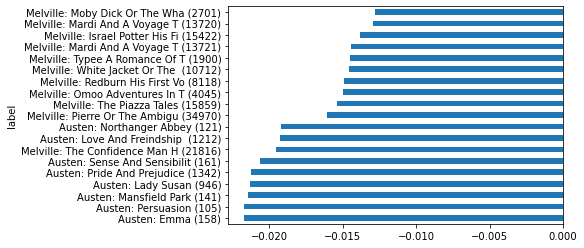

In [66]:
BOOKS.join(LIB.label).set_index('label').mean(1).sort_values().plot.barh();

In [67]:
import sys
sys.path.append(local_lib)

In [68]:
from hac2 import HAC

<Figure size 432x288 with 0 Axes>

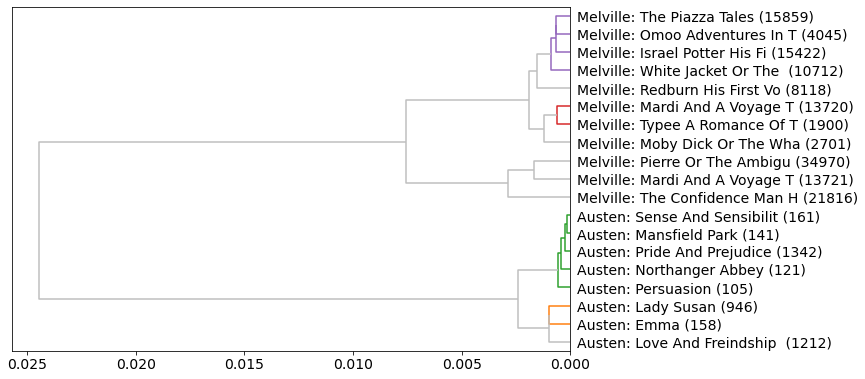

In [69]:
HAC(BOOKS, labels=BOOKS.join(LIB.label, how='left').label.to_list()).plot()